# Ag Analytics-PolarisSoilsDataLayers-Demo


In [ ]:
import requests
import json
import time
from pandas.io.json import json_normalize
from collections import defaultdict
import pandas as pd
import geopandas as gpd
import requests, zipfile, io
%matplotlib inline
%autosave 0

### API Details:

####Request URL: https://ag-analytics.azure-api.net/PolarisSoilsDataLayers/get[?inputShape][&SoilValue][&Statistics][&SoilHorizon]

####Parameters:

***inputShape - ***
The shape information for field in esriGeometryPolygon format.

***SoilValue - ***
e.g. pH, Organic Matter

***Statistics - ***
Statistics options are: min, max, mean, and variance

***SoilHorizon - ***
Soil depth in CM.


In order to get Ocp-Apim-Subscription-Key, please click on this link https://analytics.ag/Session/SignInToAPIPayment

### Request Parameters

In [ ]:
inputShape={"geometryType":"esriGeometryPolygon","features":[{"geometry":{"rings":[[[-89.045774,43.730605],[-89.04577,43.730488],[-89.045722,43.729998],[-89.045789,43.729653],[-89.045661,43.72961],[-89.045635,43.729782],[-89.045644,43.730045],[-89.045653,43.730308],[-89.045651,43.730607],[-89.041228,43.730676],[-89.041171,43.728908],[-89.041111,43.727076],[-89.042892,43.727044],[-89.044665,43.727018],[-89.046178,43.726999],[-89.046237,43.730597],[-89.045774,43.730605]]],"spatialReference":{"wkid":4326}}}]}
SoilValue="ph"
Statistics="mean"
SoilHorizon="0_5"
headers={'Ocp-Apim-Subscription-Key': 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'}
           

###  API Function

In [4]:
def get_polarissoil_datalayers(inputShape,SoilValue,Statistics,SoilHorizon,headers):
    try:
        url = "https://ag-analytics.azure-api.net/PolarisSoilsDataLayers/get?inputShape={}&SoilValue={}&Statistics={}&SoilHorizon={}".format(inputShape,SoilValue,Statistics,SoilHorizon)
     
        response = (requests.get(url,headers=headers).text)
        
        response_json = json.loads(response)
        print(response_json)
        time.sleep(0.5)
        return response_json
    
    except Exception as e:
        raise e

### Calling API Function and Displaying Response

In [5]:
polaris=get_polarissoil_datalayers(inputShape,SoilValue,Statistics,SoilHorizon,headers)

{'results': [{'paramName': 'MeanFieldValue', 'dataType': 'GPString', 'value': '6.17'}, {'paramName': 'PolygonOutput', 'dataType': 'GPFeatureRecordSetLayer', 'value': {'displayFieldName': '', 'geometryType': 'esriGeometryPolygon', 'spatialReference': {'wkid': 4326, 'latestWkid': 4326}, 'fields': [{'name': 'FID', 'type': 'esriFieldTypeOID', 'alias': 'FID'}, {'name': 'ID', 'type': 'esriFieldTypeInteger', 'alias': 'ID'}, {'name': 'GRIDCODE', 'type': 'esriFieldTypeInteger', 'alias': 'GRIDCODE'}, {'name': 'val_float', 'type': 'esriFieldTypeDouble', 'alias': 'val_float'}, {'name': 'Shape_Length', 'type': 'esriFieldTypeDouble', 'alias': 'Shape_Length'}, {'name': 'Shape_Area', 'type': 'esriFieldTypeDouble', 'alias': 'Shape_Area'}], 'features': [{'attributes': {'FID': 1, 'ID': 1, 'GRIDCODE': 6179237, 'val_float': 6.179237, 'Shape_Length': 0.0025317420608140925, 'Shape_Area': 2.097253454345347e-07}, 'geometry': {'rings': [[[-88.51322198999998, 39.598409325000034], [-88.51421776299998, 39.59846901

### Displaying Table

In [6]:
df=defaultdict(list)
resolution=5
areaOfOnePixel=resolution*resolution
totalpixels = 0
for value in polaris['results'][3]['value']: 
    val=str(round(value[0] * 100) / 100) + "-" + str(round(value[1] * 100) / 100)
    df[SoilValue].append(val)
for value in polaris['results'][2]['value']['features']: 
    totalpixels+=value['attributes']['Count']

totalArea=(totalpixels * areaOfOnePixel) * 0.000247105

for value in polaris['results'][2]['value']['features']: 
    partAcres = (value['attributes']['Count'] * areaOfOnePixel) * 0.000247105
    percentAcres = (partAcres / totalArea) * 100
    df['Area per Part (Acres)'].append(round(partAcres * 100) / 100)
    df['% of Total'].append(round(percentAcres * 100) / 100)

soil=pd.DataFrame.from_dict(df)
soil

,ph,Area per Part (Acres),% of Total
0,6.13-6.14,7.72,4.12
1,6.14-6.16,32.91,17.57
2,6.16-6.17,46.10,24.62
3,6.17-6.19,67.50,36.05
4,6.19-6.2,25.70,13.72
5,6.2-6.22,7.33,3.91


### Displaying  Map

#### Helper Functions

In [7]:
def post_converttogeojson(requestbody):
    try:
        url = "https://ogre.adc4gis.com/convert"
     
        response = (requests.post(url,files=requestbody).text)
        
        return response

    except Exception as e:
        raise e
def post_converttoshapefile(requestbody):
    try:
        url = "https://ogre.adc4gis.com/convertJson"
     
        response = (requests.post(url,data=requestbody))
        
        z = zipfile.ZipFile(io.BytesIO(response.content))
        z.extractall("./shapefiles/")
        
        time.sleep(0.5)
        return response
    
    except Exception as e:
        raise e

In [8]:
requestbody={'upload':open('./jsonfiles/polarisdata1.json','rb')}

polarisdata_geojson=post_converttogeojson(requestbody)
requestbody={'json':polarisdata_geojson,'skipFailures':"on"}
post_converttoshapefile(requestbody)

<Response [200]>

#### Displaying Output Map

,FID,ID,GRIDCODE,val_float,Shape_Leng,Shape_Area,geometry
0,1,1,6179237,6.179237,0.002532,0.0,POLYGON ((-88.51322198999998 39.59840932500003...
1,2,2,6209930,6.209930,0.002856,0.0,POLYGON ((-88.51210906999995 39.59834260500003...
2,3,3,6133198,6.133198,0.002828,0.0,POLYGON ((-88.51105472599994 39.59827938800004...
3,4,4,6148544,6.148544,0.003124,0.0,POLYGON ((-88.50994180899994 39.59821264900006...
4,5,5,6133198,6.133198,0.001599,0.0,POLYGON ((-88.50959036199998 39.59819157100003...


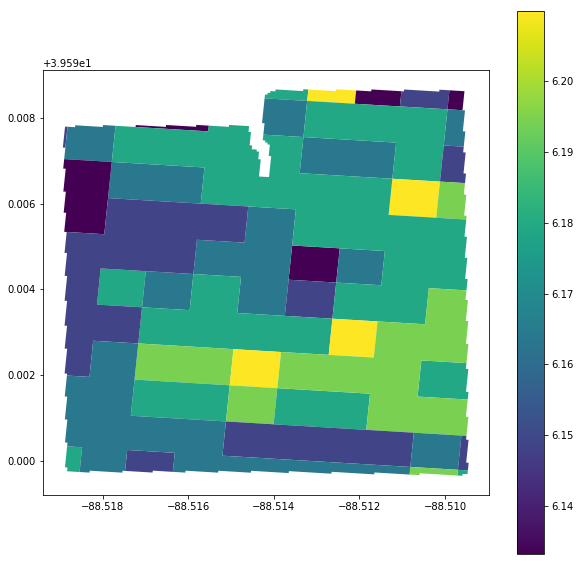

In [10]:
gdf = gpd.read_file('./shapefiles/OGRGeoJSON.shp')
gdf.plot(column='val_float', cmap=None,figsize=(10, 10),legend=True) 
gdf.head()